# Disaggregation

In [123]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation

### Dividing data into train and test set

In [124]:
train = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')
test = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')

Let us use building 1 for demo purposes

In [125]:
building = 1

Let's split data at April 30th

In [137]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")


# train_elec = train.buildings[1].elec
# test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


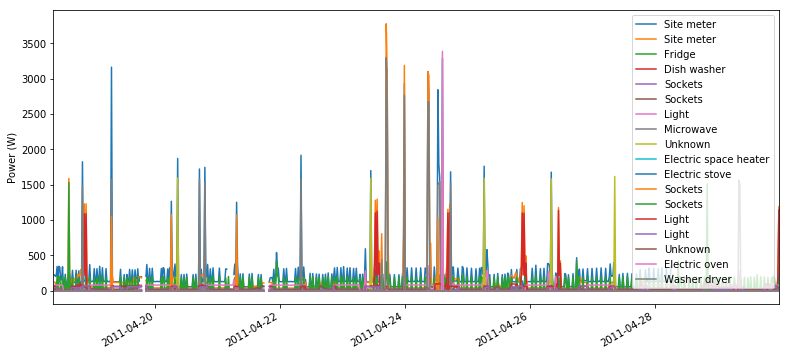

In [138]:
train_elec.plot()

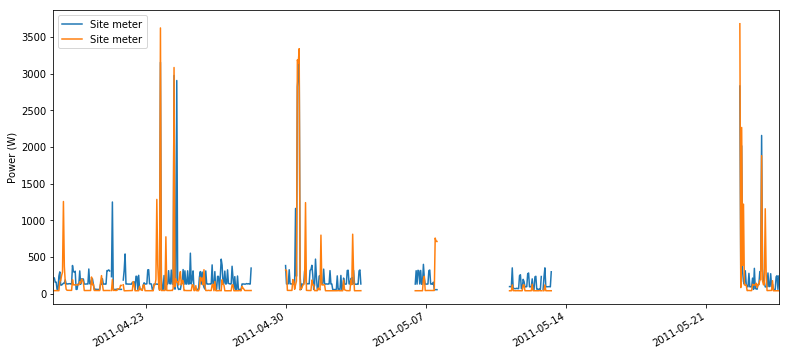

In [128]:
test_elec.mains().plot()

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [129]:
fridge_meter = train_elec['fridge']

In [113]:
fridge_df = fridge_meter.load().next()

In [114]:
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 09:22:13-04:00,6.0
2011-04-18 09:22:16-04:00,6.0
2011-04-18 09:22:20-04:00,6.0
2011-04-18 09:22:23-04:00,6.0
2011-04-18 09:22:26-04:00,6.0


In [115]:
mains = train_elec.mains()

In [116]:
mains_df = mains.load().next()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [117]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,342.820007
2011-04-18 09:22:10-04:00,344.559998
2011-04-18 09:22:11-04:00,345.140015
2011-04-18 09:22:12-04:00,341.679993
2011-04-18 09:22:13-04:00,341.029999


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [139]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [140]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

### Training and disaggregation

#### FHMM

In [141]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)
fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Runtime = 14.3326318264 seconds.


In [142]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=60).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [143]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

print(pred_overall.columns)
print("********")
print(gt_overall.columns)

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

Index([    ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)]),
            ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
       ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)]),
             ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)]),
        ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])],
      dtype='object')
********
Index([                                                                                                                                               ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
                                                                                                                                                  

In [144]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [145]:
local_timezone = train.metadata['timezone']

In [146]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [147]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [148]:
gt_overall.head()

,"ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])","ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])","ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])","ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])"
2011-04-30 00:01:00-04:00,31.0,6.0,1131.0,76.0,4.0
2011-04-30 00:02:00-04:00,29.0,6.0,1128.0,76.0,4.0
2011-04-30 00:03:00-04:00,28.0,6.0,1133.0,76.0,4.0
2011-04-30 00:04:00-04:00,28.0,6.0,1129.0,77.0,4.0
2011-04-30 00:05:00-04:00,28.0,6.0,1130.0,76.0,4.0


Using prettier names!

In [149]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [150]:
pred_overall.head()

,Sockets,Fridge,Dish washer,Light,Microwave
2011-04-30 00:01:00-04:00,22.0,192.0,0.0,2.0,1091.0
2011-04-30 00:02:00-04:00,22.0,192.0,0.0,2.0,1091.0
2011-04-30 00:03:00-04:00,22.0,192.0,0.0,2.0,1091.0
2011-04-30 00:04:00-04:00,22.0,192.0,0.0,2.0,1091.0
2011-04-30 00:05:00-04:00,22.0,192.0,0.0,2.0,1091.0


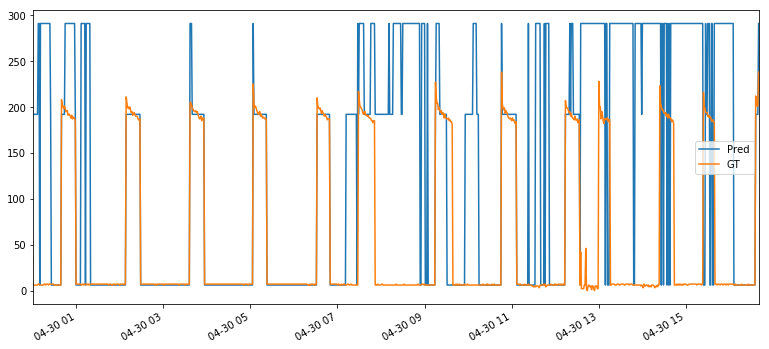

In [151]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()

In [152]:
from sklearn.metrics import mean_squared_error

In [153]:
rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [154]:
pd.Series(rms_error)

Dish washer    237.469699
Fridge          98.303702
Light           82.262046
Microwave      250.434489
Sockets         38.968234
dtype: float64

In [155]:
import math
pd_ = {}
gt_ = {}
rerror = {}
lt = 0
leng = {}
napp = []
#print(gt_overall.columns)
for appliance in gt_overall.columns:
    t = len(pred_overall[appliance])
    if lt<t:
        lt = t
        napp = []
    if lt==t:
        napp.append(appliance)
    leng[appliance]= t
    print(str(appliance) + " : "+str(t))
    

for appliance in napp:
    if (leng[appliance] < lt):
        continue
    print(appliance)
    gt_[appliance] = gt_overall[appliance]
    pd_[appliance] = pred_overall[appliance]
    #print(gt_[appliance])
    #for a,b in zip(pred_overall[appliance],gt_overall[appliance]):
    #    pd[appliance].append(a)
    #    gt[appliance].append(b)
   # print gt_[appliance][1]
    print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    #print(str(len(pred_overall[appliance]))+": "+str(len(gt_overall[appliance])))
    
print(napp)
print(lt)
s = 0
sd = 0
for i in range(lt):
    for appliance in napp:
        #if isinstance( pd[appliance][0], ( int, long ) ):
        #print( pd_[appliance] )
        #print(i)
        s = s + abs(pd_[appliance][i]-gt_[appliance][i])
        sd = sd + gt_[appliance][i]
        
acc = 1 - (1.0*s)/sd/2
print(acc)
#print(pd)


Sockets : 12450
Fridge : 12450
Dish washer : 12450
Light : 12450
Microwave : 12450
Sockets
12450, 12450
Fridge
12450, 12450
Dish washer
12450, 12450
Light
12450, 12450
Microwave
12450, 12450
['Sockets', 'Fridge', 'Dish washer', 'Light', 'Microwave']
12450
0.233743188353
